In [222]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import os, re, math, time, glob, pickle, warnings
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import fastcluster as fc
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import directed_hausdorff
from Util import colorline, mkdirs
%matplotlib inline
warnings.filterwarnings('ignore')

In [43]:
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)

# Utility Functions
color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown',
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

In [44]:
DATA_DIR=os.path.join(os.path.abspath(os.curdir), 'DATA')
PICKLE_DATA= os.path.join(DATA_DIR, "pickle_data")
NPY_DATA= os.path.join(DATA_DIR, "npy_data")
FIGURE_DIR= os.path.join(os.path.abspath(os.curdir), 'Figures')
mkdirs([PICKLE_DATA, NPY_DATA, FIGURE_DIR])

In [45]:
Stages = [8, 10, 11, 12, 13, 14, 16, 18, 20, 22]
EACH_SUB_FIG_SIZE = 5
FIGURE_FORMAT = "png"

In [212]:
def convert_data_into_np_array(INDEX_RANGE, data_save_pick_fp, load=True, number_of_pcs = 2):
    traj_list = []
    gene_pair_names=[]
    pair_indexs = range(1, INDEX_RANGE + 4)
    if load == False:
        STAGE_DATA_DIR = os.path.join(DATA_DIR, 'stage_data_v2')
        data_dict = {}
        for dir_name in os.listdir(STAGE_DATA_DIR):
            data_dir = os.path.join(STAGE_DATA_DIR, dir_name)
            if os.path.isdir(data_dir):
                dir_index = int(dir_name.split("_")[0])
                if dir_index <= INDEX_RANGE:
                    data_fp = os.path.join(data_dir, "stage_metrics.csv")
                    df = pd.read_csv(data_fp, sep=",", header=0).values
                    data_dict[dir_index] = {}
                    data_dict[dir_index]['pair_name'] = '_'.join(re.sub(r'[\[|\]|\\|\'|\s]', '', df[0, 4]).split(','))
                    pcs = df[:, 7: 7 + number_of_pcs].astype(float)
                    data_dict[dir_index]['pcs'] = pcs

                    data_dict[dir_index]['prob2d'] = []
                    for sid, stage in enumerate(Stages):
                        wild_card_path = os.path.join(data_dir, "Stage_%d_*.mat" % stage)
                        for filename in glob.glob(wild_card_path):
                            data_fp = os.path.join(data_dir, filename)
                            prob2d_arr = sio.loadmat(data_fp)
                            data_dict[dir_index]['prob2d'].append(prob2d_arr['prob2d'])

        pairs_name = ["sox2-t", "gata5-pax8", "lhx1-pax8"]
        for pid, pair in enumerate(pairs_name):
            base_dir = os.path.join(DATA_DIR, "target_gene_pairs")
            input_fp = os.path.join(base_dir, pair + ".csv")
            pcs = pd.read_csv(input_fp, sep=",", header=0).values
            d_id = INDEX_RANGE + pid + 1
            data_dict[d_id] ={}
            # the elements of each entry in data dict
            data_dict[d_id]['pair_name'] = pair
            data_dict[d_id]['pcs'] = pcs
            data_dict[d_id]['prob2d'] = []

            stage_prob2d_gene_pair_dir = os.path.join(base_dir, pair)
            for sid, stage in enumerate(Stages):
                wild_card_path = os.path.join(stage_prob2d_gene_pair_dir, "Stage_%d_*.mat" % stage)
                for filename in glob.glob(wild_card_path):
                    data_fp = os.path.join(stage_prob2d_gene_pair_dir, filename)
                    prob2d_arr = sio.loadmat(data_fp)
                    data_dict[d_id]['prob2d'].append(prob2d_arr['prob2D'])
        with open(data_save_pick_fp, 'wb') as handle:
            pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(data_save_pick_fp, 'rb') as handle:
            data_dict = pickle.load(handle)
    for key in pair_indexs:
        traj_list.append(data_dict[key]['pcs'])
        gene_pair_names.append(data_dict[key]['pair_name'])
        # plt.plot(traj[:, 0], traj[:, 1])
    # plt.show()
    return [data_dict, traj_list, gene_pair_names]
def hausdorff(u, v):
    # 3 - Distance matrix
    d = np.linalg.norm(u - v)*5 + max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d
def calc_distance_matrix(distance_fp, traj_lst):
    ts = time.time()
    traj_count = len(traj_lst)
    D = np.zeros((traj_count, traj_count))

    # This may take a while
    for i in range(traj_count):
        for j in range(i + 1, traj_count):
            distance = hausdorff(traj_lst[i], traj_lst[j])
            D[i, j] = distance
            D[j, i] = distance
    te = time.time()
    print("%d Distances computed in %d seconds" % (traj_count, te - ts))
    np.save(distance_fp, D)
def plot_cluster(INDEX_RANGE, traj_lst, cluster_lst, run_name, fig_format="png", color_palette=None):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    N_CLUSTER = len(np.unique(cluster_lst))
    N_COL = 5
    N_ROW = int(math.ceil(float(N_CLUSTER) / N_COL))
    c_arr = np.array([(time_point + 1.) / 10. for time_point in range(10)])
    traj_lst = np.array(traj_lst)
    cluster_lst = np.array(cluster_lst)
    fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
    for index, (traj, cluster) in enumerate(zip(traj_lst, cluster_lst)):
        row = cluster // N_COL
        col = cluster % N_COL
        if N_ROW > 1:
            ax = axs[row][col]
        else:
            ax = axs[cluster]
        data_index = index + 1
        if data_index > INDEX_RANGE:
            colorline(ax, traj[:, 0], traj[:, 1], c_arr, linestyle='dashed')
            ax.text(0, 0, data_dict[data_index]['pair_name'], color='black')
        else:

            colorline(ax, traj[:, 0], traj[:, 1], c_arr)
        ax.set_xlim(-20, 45)
        ax.set_ylim(-20, 40)
        if color_palette:
            ax.set_title("cluster %d" % (cluster + 1), backgroundcolor=color_palette[cluster])
        else:
            ax.set_title("cluster %d" % (cluster + 1))
    fig_dir = os.path.join(FIGURE_DIR, run_name)
    mkdirs([fig_dir])
    fig_fp = os.path.join(fig_dir, "cluster.%s" % fig_format)
    plt.savefig(fig_fp, dpi=200)
    plt.show()
def plot_heatmap_serie_of_each_cluster(data_dict, N_CLUSTER, cluster_lst, run_name, fig_format="png", TARGET_CLUSTER_IDs=None):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    data_dict = data_dict[0]
    N_COL = 10
    Max_NROW = 5
    TICKS = range(0, 21, 5)
    N_SUBFIG_PER_FIG = Max_NROW * N_COL
    cluster_lst = np.array(cluster_lst)
    fig_dir = os.path.join(FIGURE_DIR, run_name)
    mkdirs([fig_dir])
    if TARGET_CLUSTER_IDs:
        cluster_ids = TARGET_CLUSTER_IDs
    else:
        cluster_ids = range(N_CLUSTER)
    for cluster in cluster_ids:
        gene_pair_indexs = np.where(cluster_lst == cluster)[0]
        n_gene_pairs_in_cluster = len(gene_pair_indexs)
        NFIG = int(math.ceil(float(n_gene_pairs_in_cluster) / Max_NROW))
        sub_fig_dir = os.path.join(fig_dir, "cluster_%d" % (cluster + 1))
        mkdirs([sub_fig_dir])
        for i in range(NFIG):
            if NFIG > 1:
                fig_fp = os.path.join(sub_fig_dir, "cluster_%d_%d.%s" % (cluster + 1, i, fig_format))
            else:
                fig_fp = os.path.join(sub_fig_dir, "cluster_%d.%s" % (cluster + 1, fig_format))
            base_index = i * N_SUBFIG_PER_FIG
            N_remaining_files = n_gene_pairs_in_cluster * N_COL - base_index
            N_ROW = int(math.ceil(float(N_remaining_files) / N_COL)) if N_remaining_files <= N_SUBFIG_PER_FIG else Max_NROW
            
            fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
            SUB_FIG_RANGE = N_SUBFIG_PER_FIG if N_remaining_files > N_SUBFIG_PER_FIG else N_remaining_files
            plt.set_cmap('viridis_r')
            for j in range(SUB_FIG_RANGE):
                row = j // N_COL
                col = j % N_COL
                if N_ROW == 1:
                    ax = axs[col]
                else:
                    ax = axs[row][col]
                gene_pair_id = gene_pair_indexs[i * Max_NROW + row] + 1
                prob2d_array = data_dict[gene_pair_id]['prob2d']  # shape 21* 21
                prob2d = prob2d_array[col]
                q_potential = -np.log(np.abs(prob2d))
                cax = ax.pcolormesh(q_potential, vmin=3, vmax=14)
                ax.set_yticks(TICKS)
                ax.set_xticks(TICKS)
                if row == 0:
                    ax.set_title("Stage %d" % Stages[col])
                if col == 0:
                    ax.set_ylabel(data_dict[gene_pair_id]['pair_name'])
                if j == 0:
                    fig.colorbar(cax, ax=ax)
            plt.savefig(fig_fp, dpi=200)
            print("cluster %d" % (cluster + 1))
            plt.show()

### 1. Preprocessing data and store it into data dict and trajactories list

In [120]:
INDEX_RANGE = 214
run_name = "%d_gene_pairs_v2" % INDEX_RANGE
pickle_fp = os.path.join(PICKLE_DATA, "%s.pkl" % run_name)
[data_dict, traj_list, gene_pair_names] = convert_data_into_np_array(INDEX_RANGE, pickle_fp, load=False)

### 2. Calculate distance matrix by pair-wise Euclidean distance

In [241]:
metric = "directed_hausdorff_plus_pair_wise_euclidean" #pair_wise_euclidean_distance
distance_fp = os.path.join(NPY_DATA, "%s_%s.npy" % (run_name, metric))
calc_distance_matrix(distance_fp, traj_list)

217 Distances computed in 2 seconds


### 3. Hierarchical Clustering by trjactory distance matrix

In [277]:
cm = plt.get_cmap('gist_rainbow')
p_dist = np.load(distance_fp)
Z = fc.linkage(p_dist, method="ward")
distance_threshold=7200
labels = fcluster(Z, t=distance_threshold, criterion="distance") - 1
N_LABEL_CATEGORY=len(np.unique(labels))
df = pd.DataFrame(data=p_dist, index=gene_pair_names, columns=gene_pair_names)
df['cluster_label']= labels
color_palette = dict(zip(df.cluster_label.unique(), [cm(1. * i / N_LABEL_CATEGORY) for i in range(N_LABEL_CATEGORY)]))
D_leaf_colors={gid:rgb2hex(color_palette[labels[gid]]) for gid, gpn in enumerate(gene_pair_names)}#
link_cols = {}
dflt_col = "#808080"
for i, i12 in enumerate(Z[:,:2].astype(int)):
    c1, c2 = (link_cols[x] if x > len(Z) else D_leaf_colors[x] for x in i12)
    link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col

In [278]:
def plot_hierarchical_cluster(df, Z, color_palette, distance_threshold, labels, run_name, fig_format="png"):
    row_colors = df.cluster_label.map(color_palette)
    fig1= plt.figure(figsize=(30, 30))
    g = sns.clustermap(df, method="ward", col_cluster=True, col_colors=row_colors)
    fig_dir = os.path.join(FIGURE_DIR, run_name)
    mkdirs([fig_dir])
    fig_fp1 = os.path.join(fig_dir, "hierarchical_cluster.%s" % fig_format)
    fig1.savefig(fig_fp1, dpi=200)

    fig2= plt.figure(figsize=(30, 30))
    dendrogram(Z, labels=df.index, leaf_rotation=90, orientation="top", 
               leaf_font_size = 8, distance_sort='ascending', color_threshold= distance_threshold, 
               above_threshold_color="black", 
               link_color_func=lambda x: link_cols[x])
    fig_fp2 = os.path.join(fig_dir, "cluster_dendrogram.%s" % fig_format)
    fig2.savefig(fig_fp2, dpi=200)

<Figure size 2160x2160 with 0 Axes>

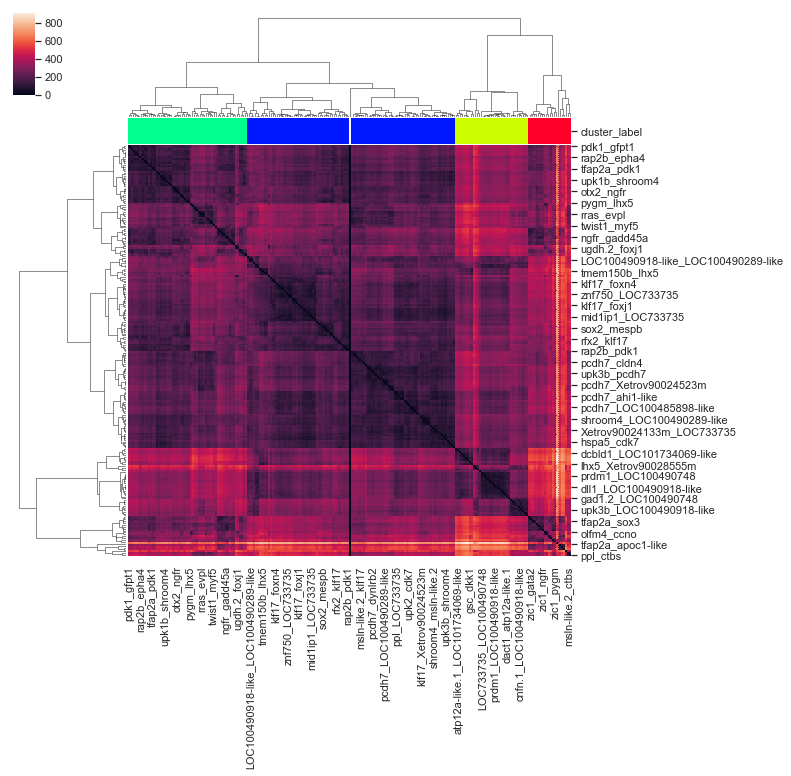

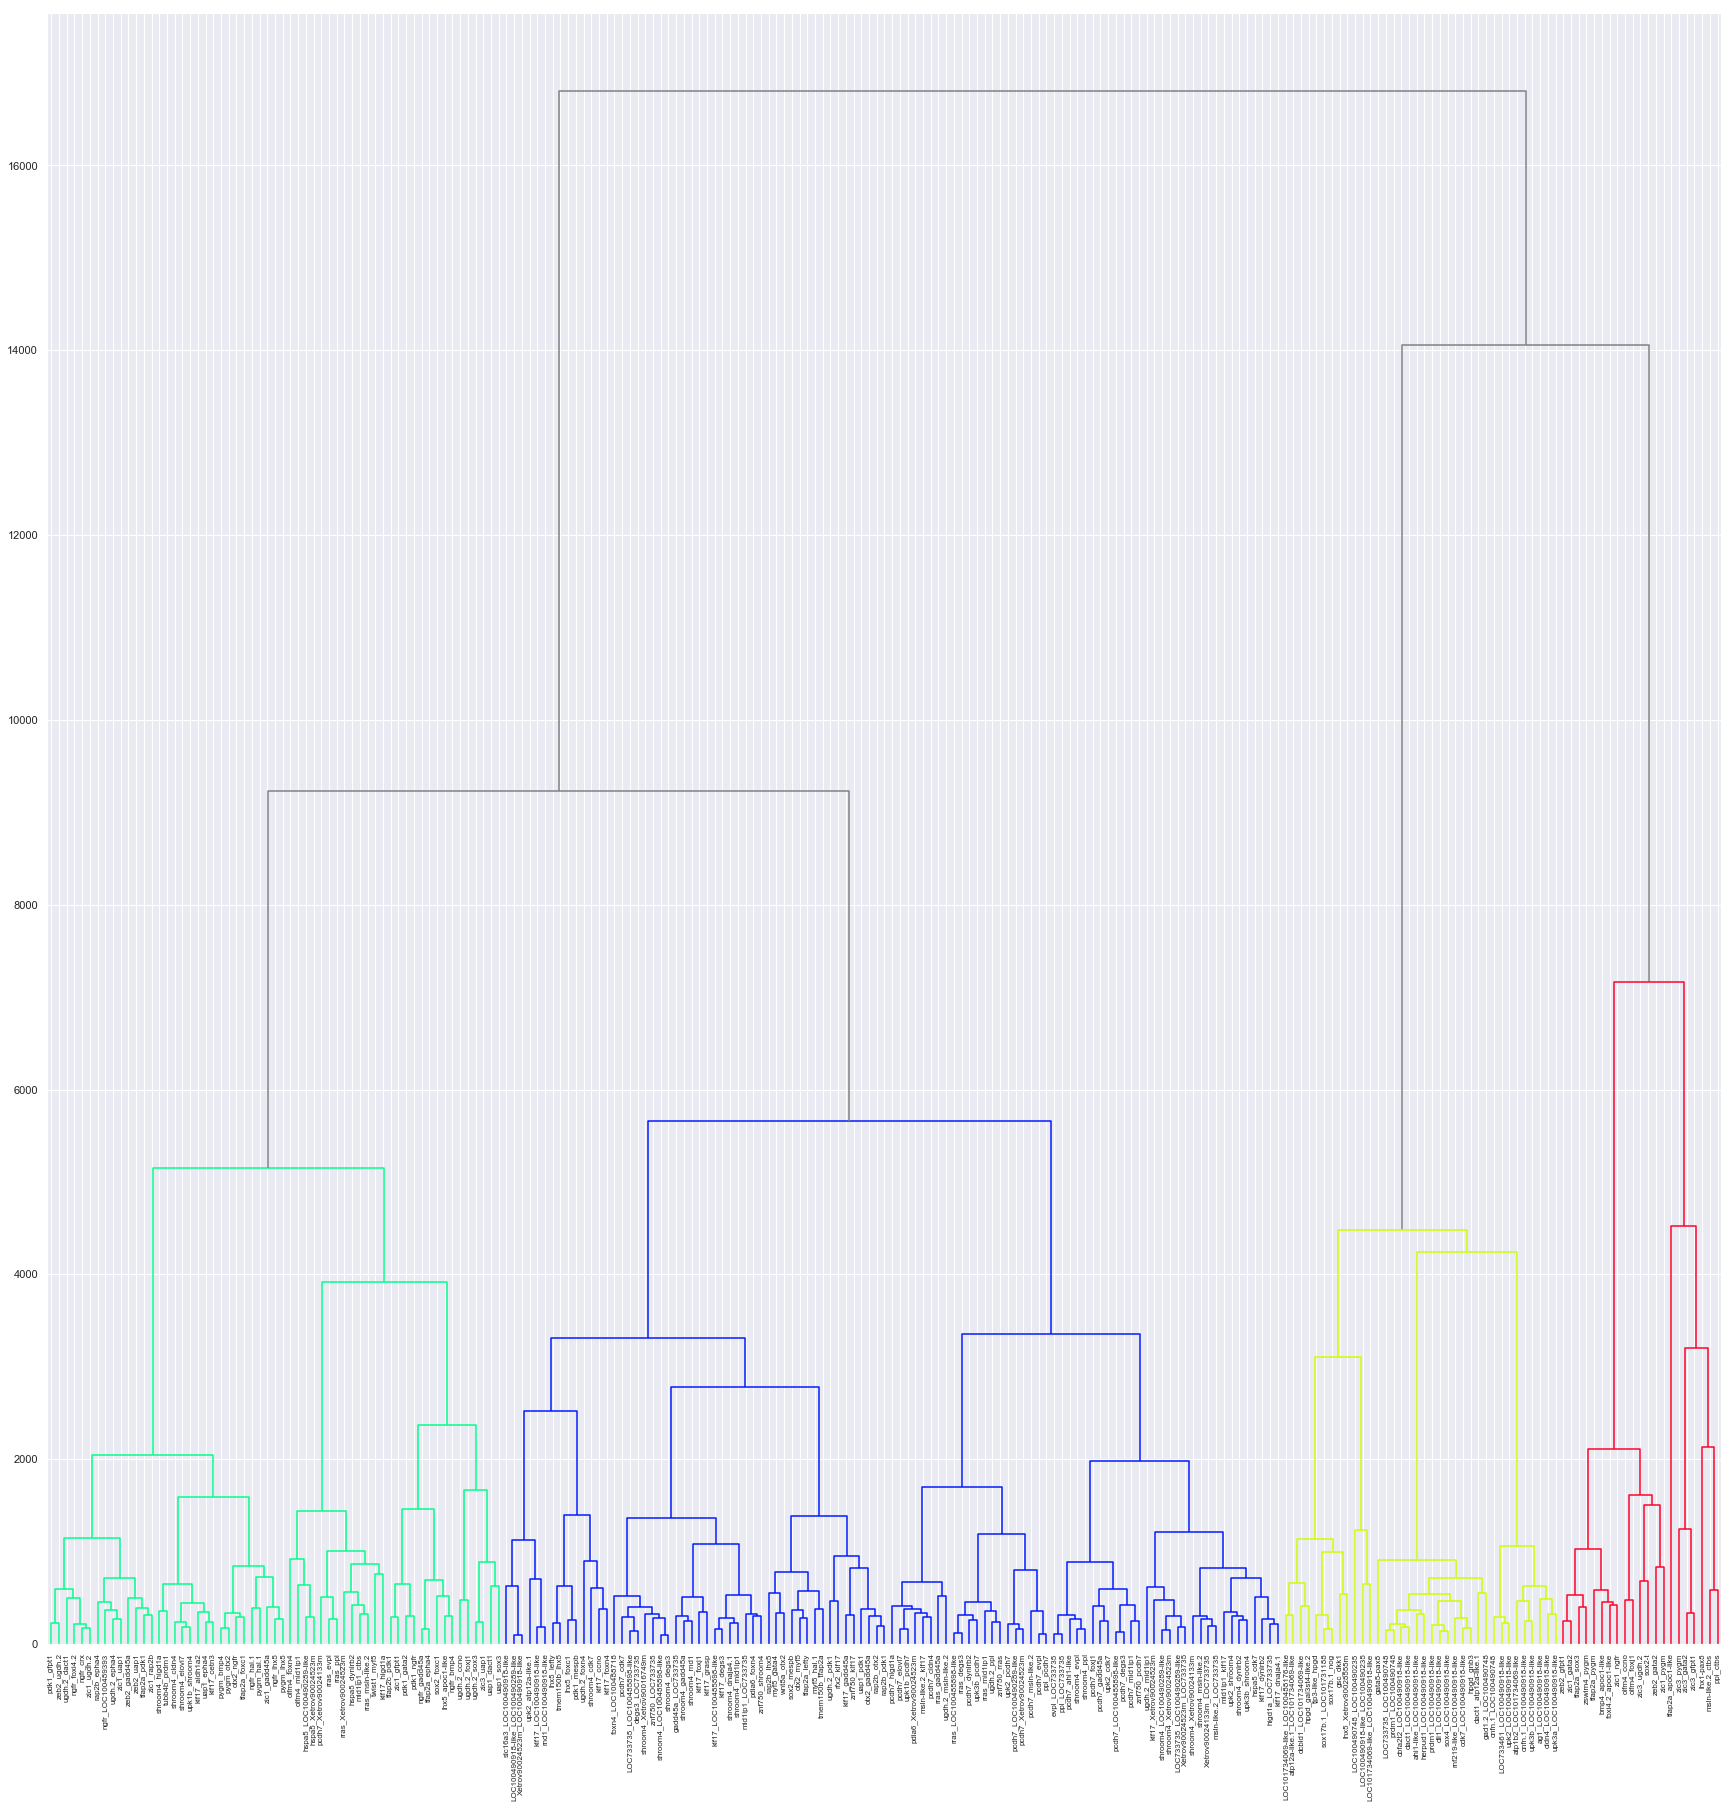

In [279]:
plot_hierarchical_cluster(df, Z, color_palette, distance_threshold, labels, run_name, fig_format="svg")

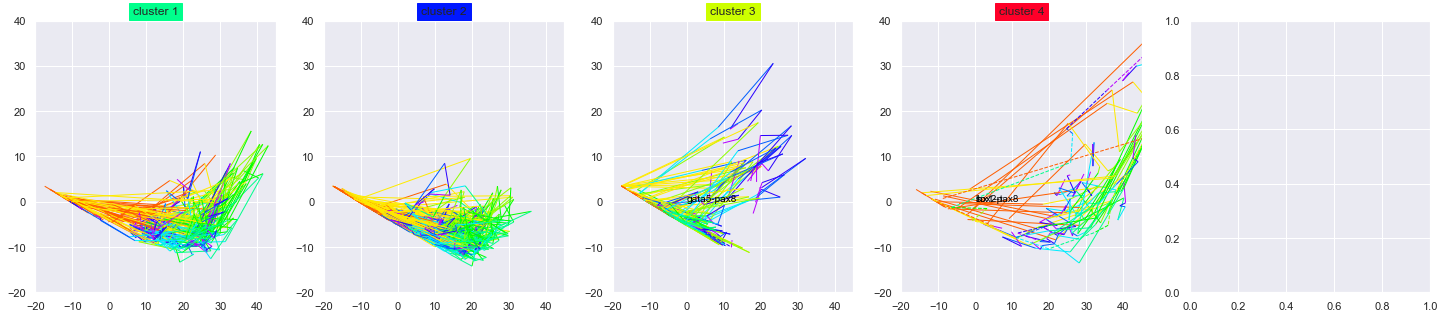

In [280]:
plot_cluster(INDEX_RANGE, traj_list, labels, run_name, FIGURE_FORMAT, color_palette)

cluster 4


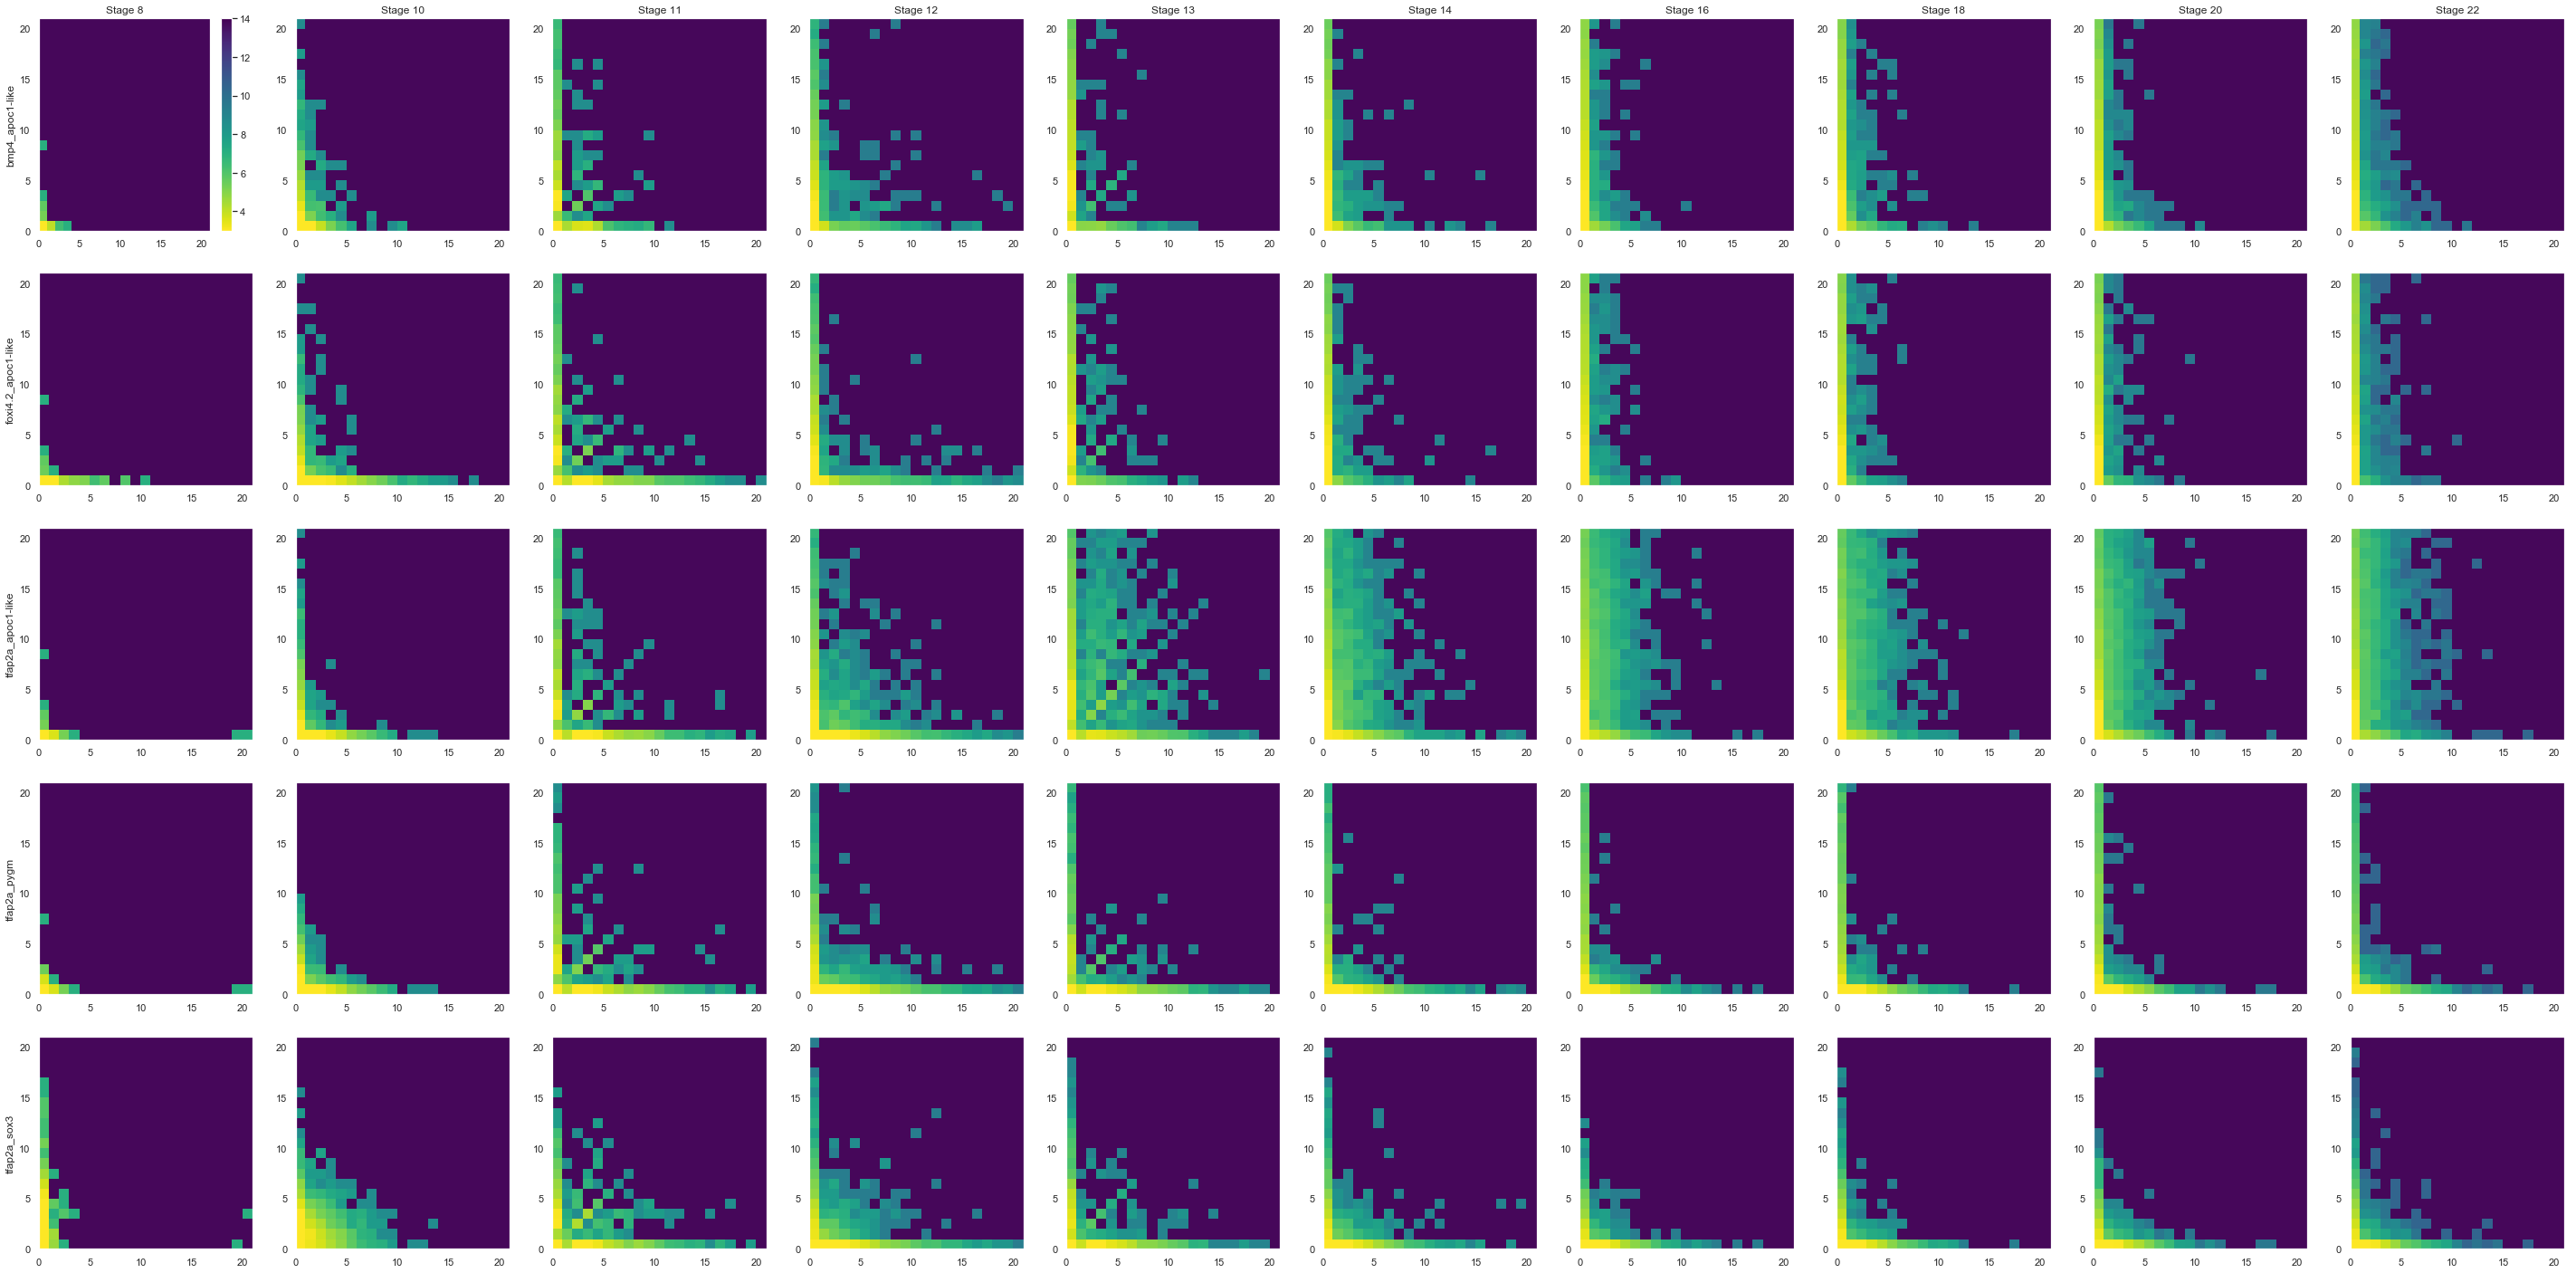

cluster 4


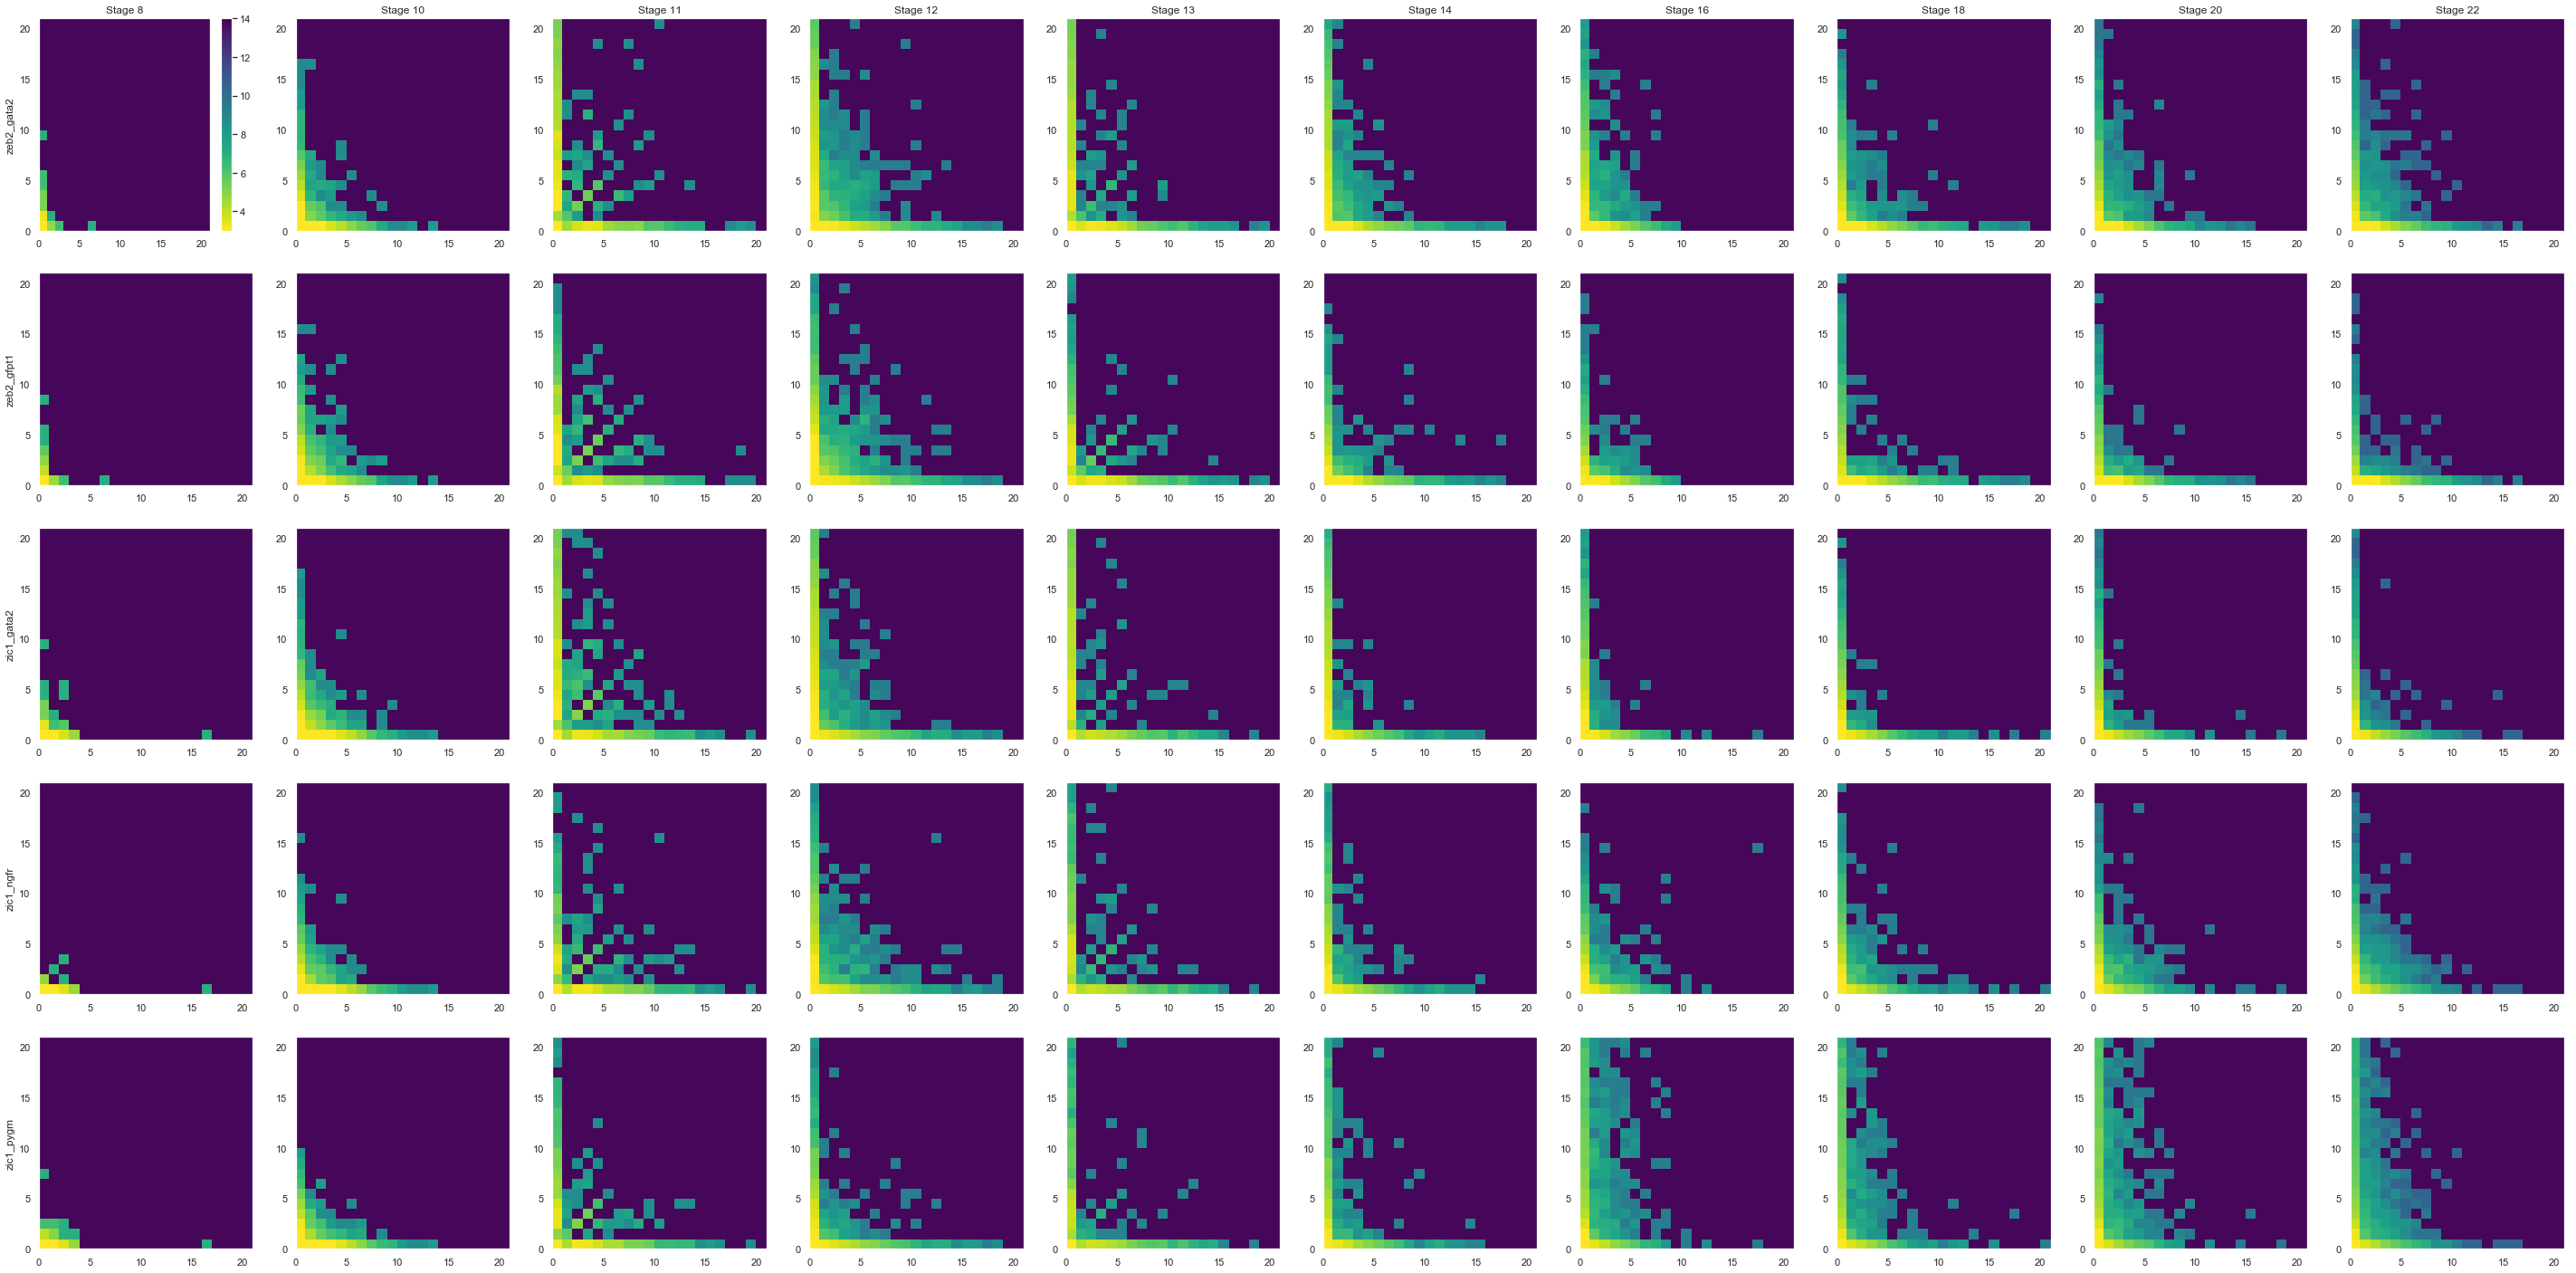

cluster 4


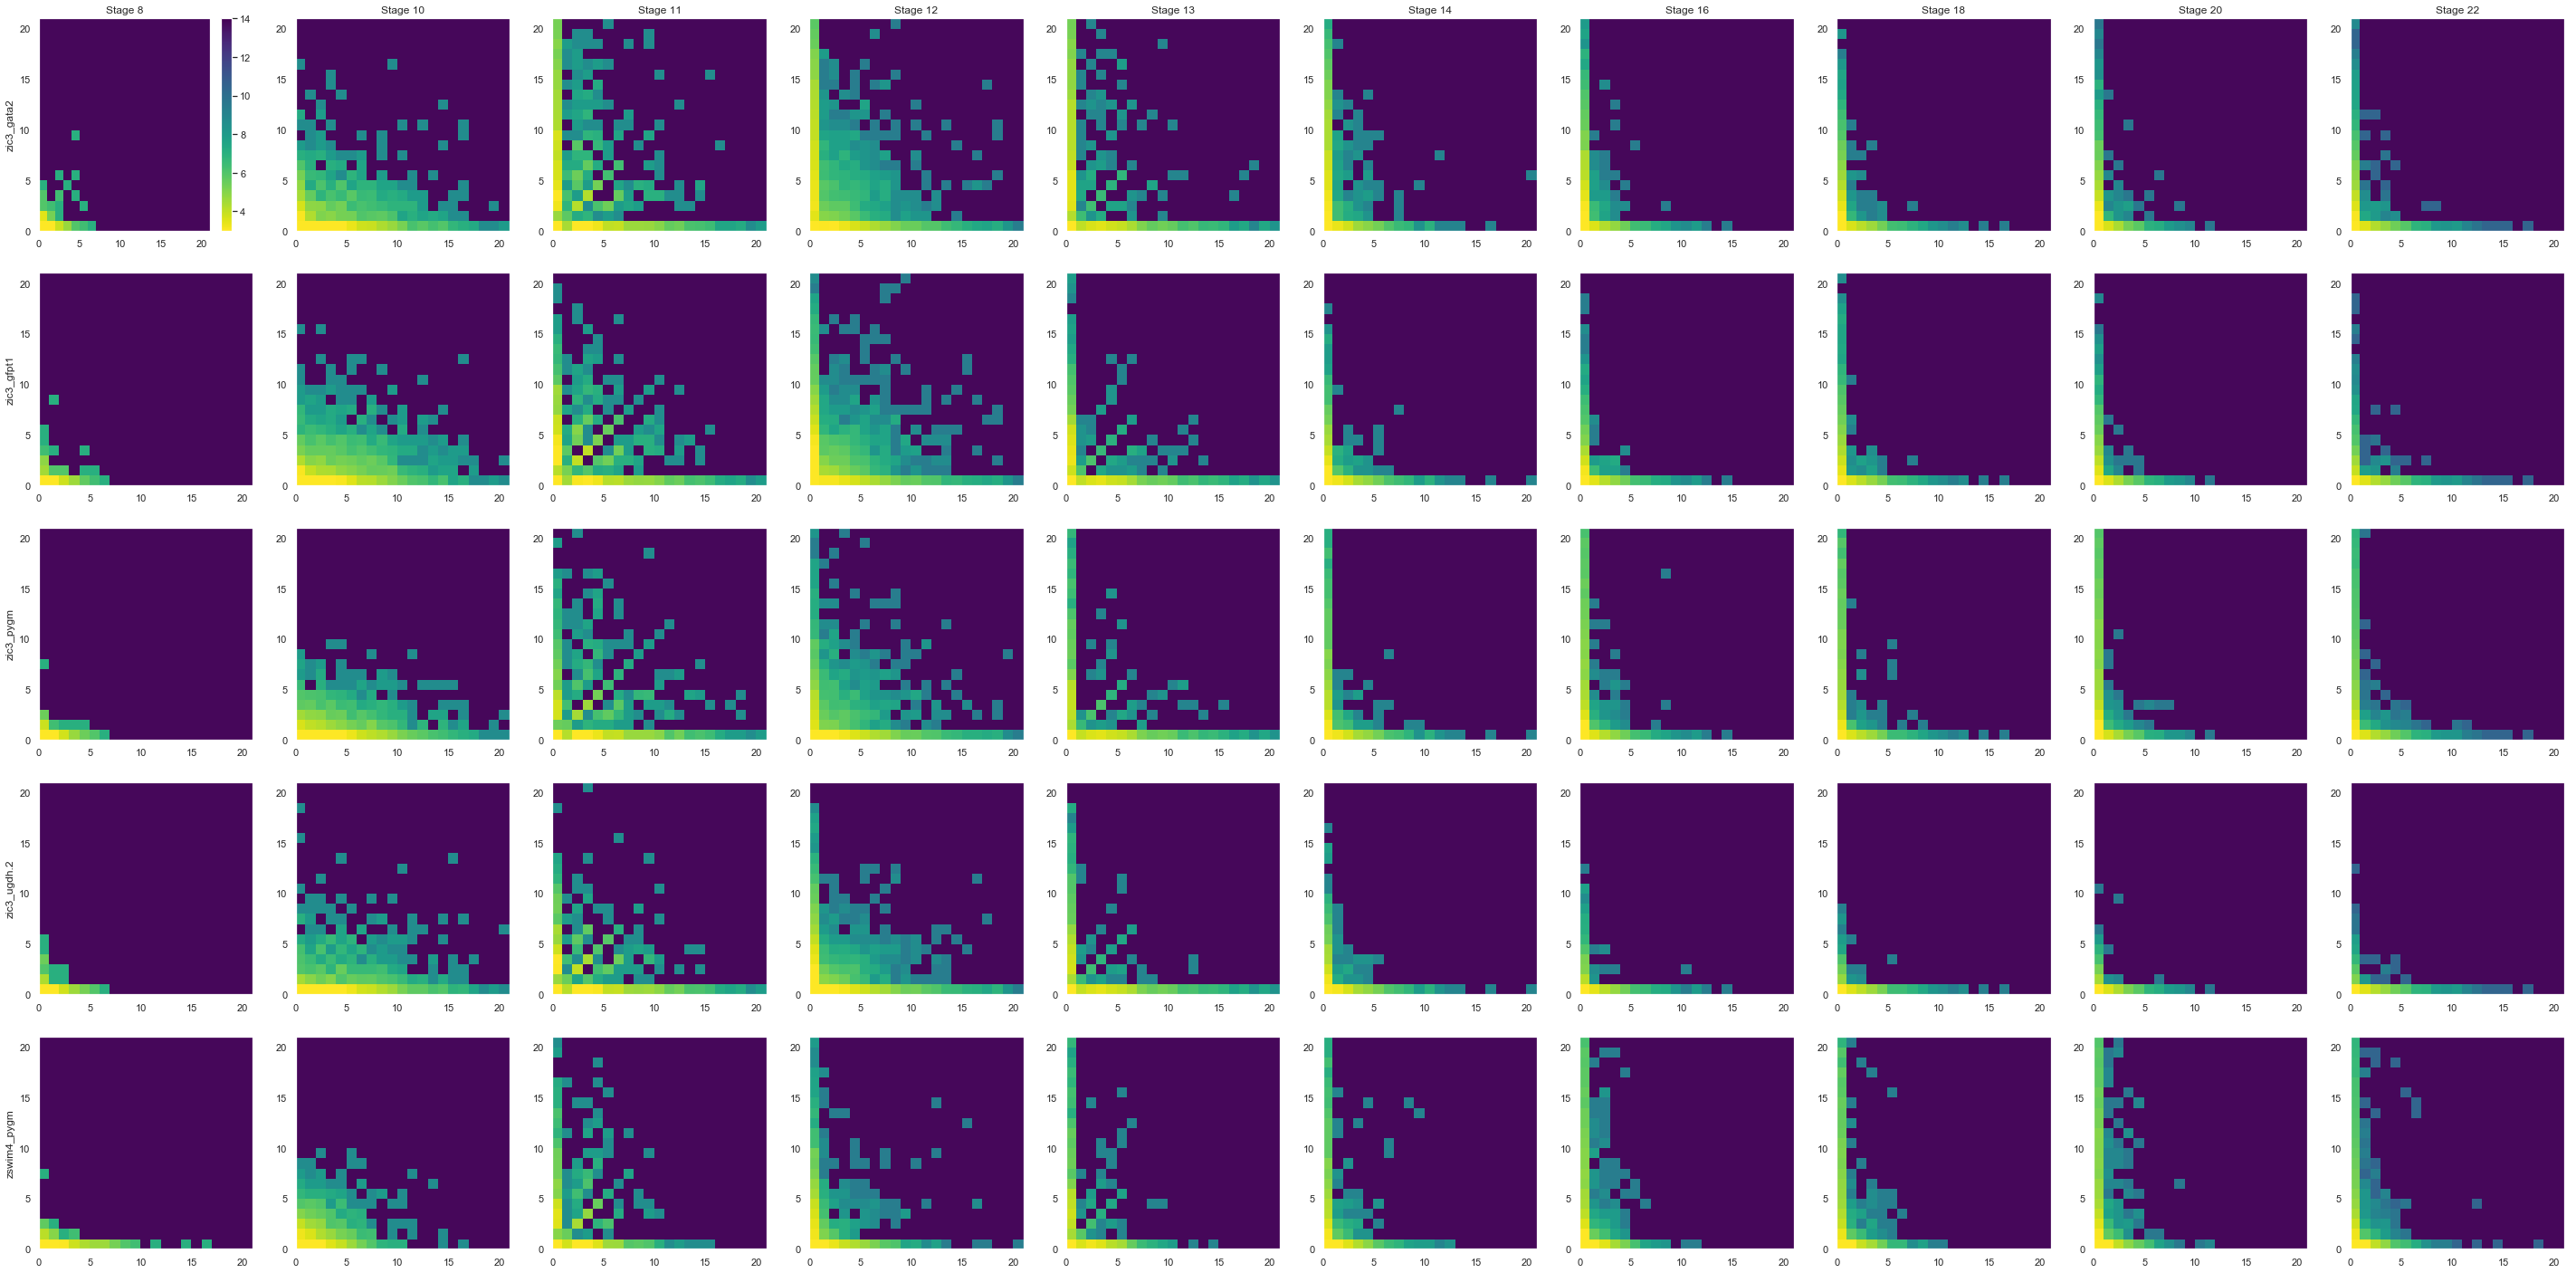

In [ ]:
TARGET_CLUSTER_IDs = [3]
plot_heatmap_serie_of_each_cluster([data_dict], len(np.unique(labels)), labels, run_name, FIGURE_FORMAT, TARGET_CLUSTER_IDs)